<h1>Skin detector</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras import backend as K
from keras.utils import np_utils
import os

TRAIN_PATH = '../datasets/skin_cancer/train'
TEST_PATH = '../datasets/skin_cancer/test'
#tensorflow = channel last
#theano = channel first
print(K.backend())
K.set_image_data_format(data_format='channels_last')

tensorflow


"The data consists of two folders with each <strong>1800</strong> pictures <strong>(224x224)</strong> of the two types of moles."</br>
<strong>The goal is to predict if a skin spot is either benign or malignant.</strong>

<h2>Building datasets</h2>

In [2]:
def create_array(train_test_path, benign_malign_path, width, height):
    complete_path = f'{train_test_path}/{benign_malign_path}/'
    X = np.empty(shape=(len(os.listdir(complete_path)), width, height)) #1440 images of 224x224 pixels in RGB but for computation reason we will use grayscale
    for i, image_file in enumerate(os.listdir(complete_path)):
        im = ImageOps.grayscale(Image.open(f'{complete_path}{image_file}')) #from (224, 224, 3) to (224, 224)
        X[i] = np.array(im)
    if benign_malign_path == 'benign':
        y = np.zeros(shape=X.shape[0])
    elif benign_malign_path == 'malignant':
        y = np.ones(shape=X.shape[0])
    else:
        print('benign_malign_path must be "benign" or "malign"')
    return X, y

def shuffle_in_unison(a, b):
    """
        Shuffle two array in the same order (see: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison)
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [3]:
X_train_benign, y_train_benign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='benign', width=224, height=224)
X_train_malign, y_train_malign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='malignant', width=224, height=224)

In [4]:
X_test_benign, y_test_benign = create_array(train_test_path=TEST_PATH, benign_malign_path='benign', width=224, height=224)
X_test_malign, y_test_malign = create_array(train_test_path=TEST_PATH, benign_malign_path='malignant', width=224, height=224)

In [5]:
print(X_train_benign.shape, y_train_benign.shape)
print(X_train_malign.shape, y_train_malign.shape)

X_train = np.concatenate((X_train_benign, X_train_malign), axis=0)
y_train = np.concatenate((y_train_benign, y_train_malign), axis=0)
print(X_train.shape, y_train.shape)

(1440, 224, 224) (1440,)
(1197, 224, 224) (1197,)
(2637, 224, 224) (2637,)


In [6]:
print(X_test_benign.shape, y_test_benign.shape)
print(X_test_malign.shape, y_test_malign.shape)

X_test = np.concatenate((X_test_benign, X_test_malign), axis=0)
y_test = np.concatenate((y_test_benign, y_test_malign), axis=0)
print(X_test.shape, y_test.shape)

(360, 224, 224) (360,)
(300, 224, 224) (300,)
(660, 224, 224) (660,)


In [7]:
shuffle_in_unison(X_train, y_train)
shuffle_in_unison(X_test, y_test)

<h2>Processing data</h2>

In [8]:
def resize(X, y):
    X = X[:, :, :, np.newaxis]
    y = np.reshape(y, newshape=(y.shape[0], 1))
    return X, y

def rescale(X, y):
    X = X.astype('float32')
    return X/255, np_utils.to_categorical(y)

<h3>Resizing :</h3>

In [9]:
#we need a n * (width, height, 1) shape (channels_last)
X_train, y_train = resize(X_train, y_train)
X_test, y_test = resize(X_test, y_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2637, 224, 224, 1) (660, 224, 224, 1)
(2637, 1) (660, 1)


<h3>Rescaling :</h3>

In [10]:
X_train, y_train = rescale(X_train, y_train)

In [11]:
X_test, y_test = rescale(X_test, y_test)

In [11]:
X_train = X_train.astype("float32")
X_train /= 255
y_train = np_utils.to_categorical(y_train)

<h2>Modelling :</h2>

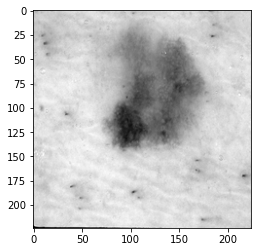

In [12]:
plt.imshow(X_test[0], cmap='gray')

In [60]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping

OPTIM = SGD(learning_rate=0.01)
BATCH_SIZE = 293 #(2637/293 = 9)
VALIDATION_SPLIT = 0.2

In [80]:
class SkinNet :
    def __init__(self, input_shape, num_class):
        self.model = Sequential()
        self.input_shape = input_shape
        self.num_class = num_class
        
    def build(self):
        self.model.add(Conv2D(filters=64, kernel_size=(7, 7), padding='same', input_shape=self.input_shape))
        self.model.add(Activation(activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
        
        self.model.add(Flatten())
        self.model.add(Dense(units=100, activation='relu'))
        self.model.add(Dense(units=self.num_class, activation='softmax'))
        
        return self.model

In [81]:
model = SkinNet(input_shape=(224, 224, 1), num_class=2)
model = model.build()

In [82]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      3200      
                                                                 
 activation_7 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 200704)            0         
                                                                 
 dense_14 (Dense)            (None, 100)               20070500  
                                                                 
 dense_15 (Dense)            (None, 2)                 202       
                                                      

In [83]:
model.compile(optimizer=OPTIM, loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [85]:
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=15, callbacks=[early_stop], validation_split=VALIDATION_SPLIT)

Epoch 1/15
8/8 [==============================] - 51s 6s/step - loss: 0.6945 - accuracy: 0.4993 - val_loss: 0.6907 - val_accuracy: 0.6307
Epoch 2/15
8/8 [==============================] - 50s 6s/step - loss: 0.6876 - accuracy: 0.5420 - val_loss: 0.6801 - val_accuracy: 0.5814
Epoch 3/15
8/8 [==============================] - 50s 6s/step - loss: 0.6867 - accuracy: 0.5491 - val_loss: 0.6808 - val_accuracy: 0.5833
Epoch 4/15
8/8 [==============================] - 51s 6s/step - loss: 0.6864 - accuracy: 0.5477 - val_loss: 0.6775 - val_accuracy: 0.5814
Epoch 5/15
8/8 [==============================] - 51s 6s/step - loss: 0.6878 - accuracy: 0.5396 - val_loss: 0.6864 - val_accuracy: 0.6420
Epoch 6/15
8/8 [==============================] - 51s 6s/step - loss: 0.6835 - accuracy: 0.5557 - val_loss: 0.6761 - val_accuracy: 0.5966
Epoch 7/15
8/8 [==============================] - 51s 6s/step - loss: 0.6850 - accuracy: 0.5439 - val_loss: 0.6741 - val_accuracy: 0.5814
Epoch 8/15
8/8 [==================

<ul>
    <li>Increasing learning_rate (from 0.01 to 0.1) decreased accuracy</li>
    <li>Decreasing learning rate (from 0.01 to 0.001) decreased accuracy</li>
    <li>Increasing Dense units (from 100 to 250) decreased accuracy</li>
</ul>

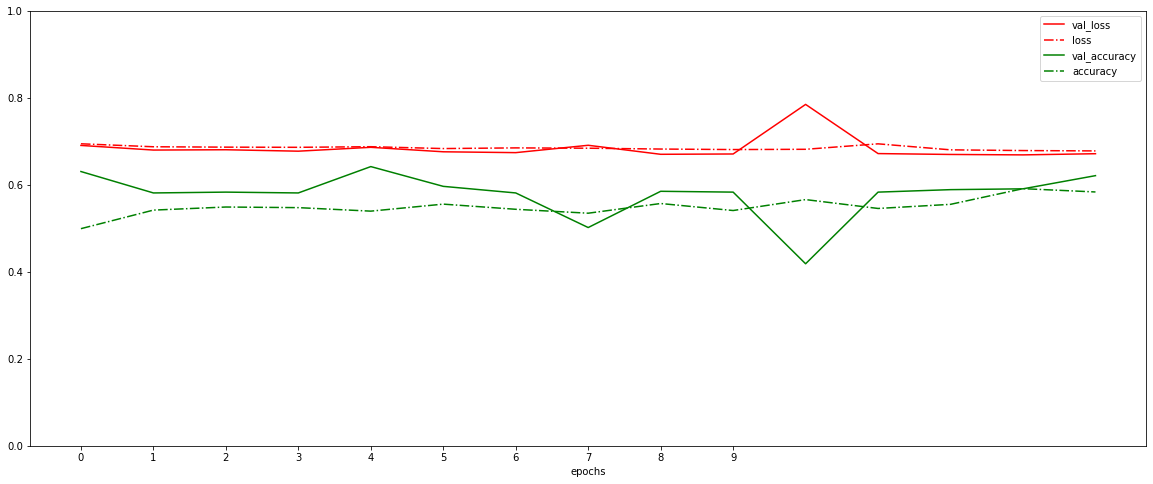

In [86]:
figure = plt.figure(figsize=(20, 8))
ax = figure.add_subplot(1, 1, 1)
ax.plot(history.history['val_loss'], color='red', ls='-', label='val_loss')
ax.plot(history.history['loss'], color='red', ls='-.', label='loss')

ax.plot(history.history['val_accuracy'], color='green', ls='-', label='val_accuracy')
ax.plot(history.history['accuracy'], color='green', ls='-.', label='accuracy')

ax.set_xlabel('epochs')
ax.set_xticks(range(0, 10))
ax.set_ylim(0.0, 1.0, 0.1)
plt.legend()

In [87]:
score = model.evaluate(x=X_test, y=y_test)

21/21 [==============================] - 2s 88ms/step - loss: 0.6756 - accuracy: 0.5909


In [88]:
print(f'Test loss : {score[0]:.2f}')
print(f'Test accuracy : {score[1]*100:.2f}%')

Test loss : 0.68
Test accuracy : 59.09%


In [70]:
#saving the architecture
model_json = model.to_json()
with open('models/skin3.json', 'w') as filin:
    filin.write(model_json)
    
#saving the weights
model.save_weights(filepath='models/skin3.h5')